# Курс "Методы современной прикладной статистики"
# 3 курс ФПМИ МФТИ, весна 2022
## Домашнее задание 4. Множественная проверка статистических гипотез.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.special as spss
import seaborn as sns
import pandas as pd
sns.set(style='darkgrid', font_scale=1.4)
%matplotlib inline
%config InlineBackend.figure_format="retina"  # only for retina display

In [2]:
import warnings
warnings.filterwarnings('ignore')
from scipy.optimize import minimize, fmin

In [3]:
from statsmodels.stats.diagnostic import lilliefors

In [4]:
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multitest import fdrcorrection
from sklearn.ensemble import IsolationForest

### Задача 1

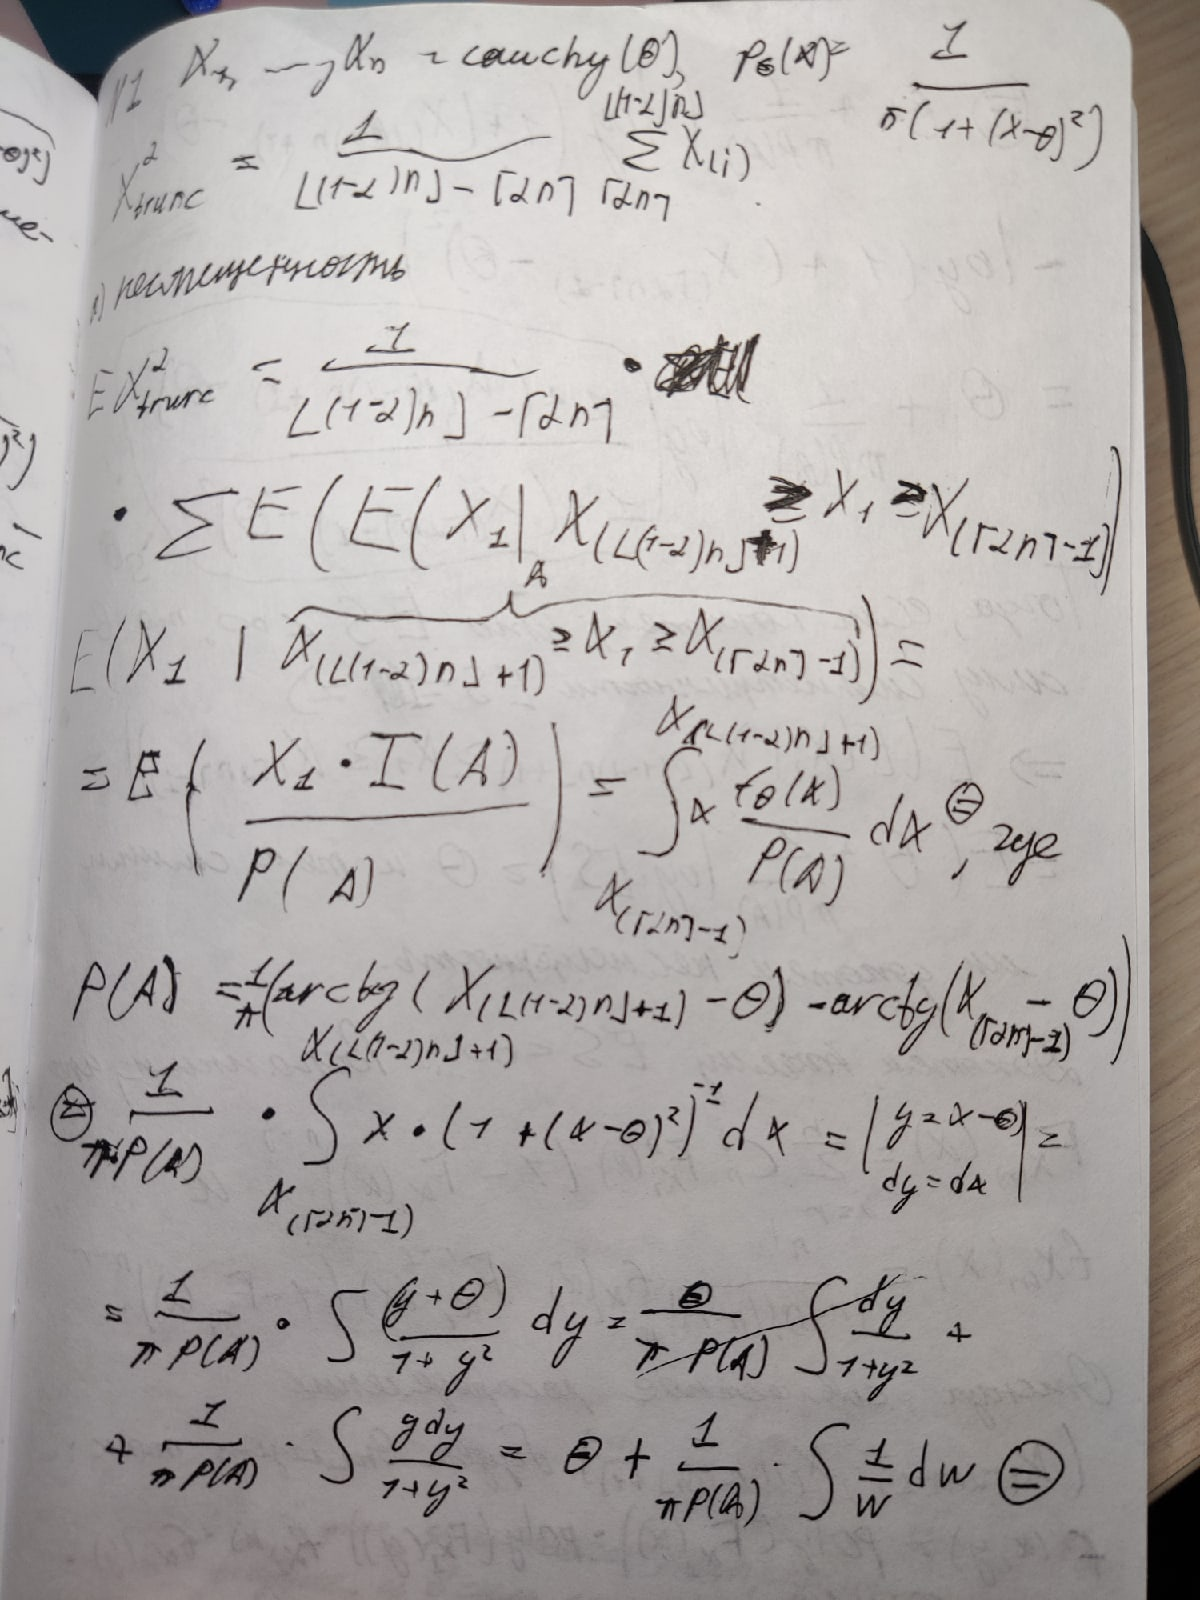

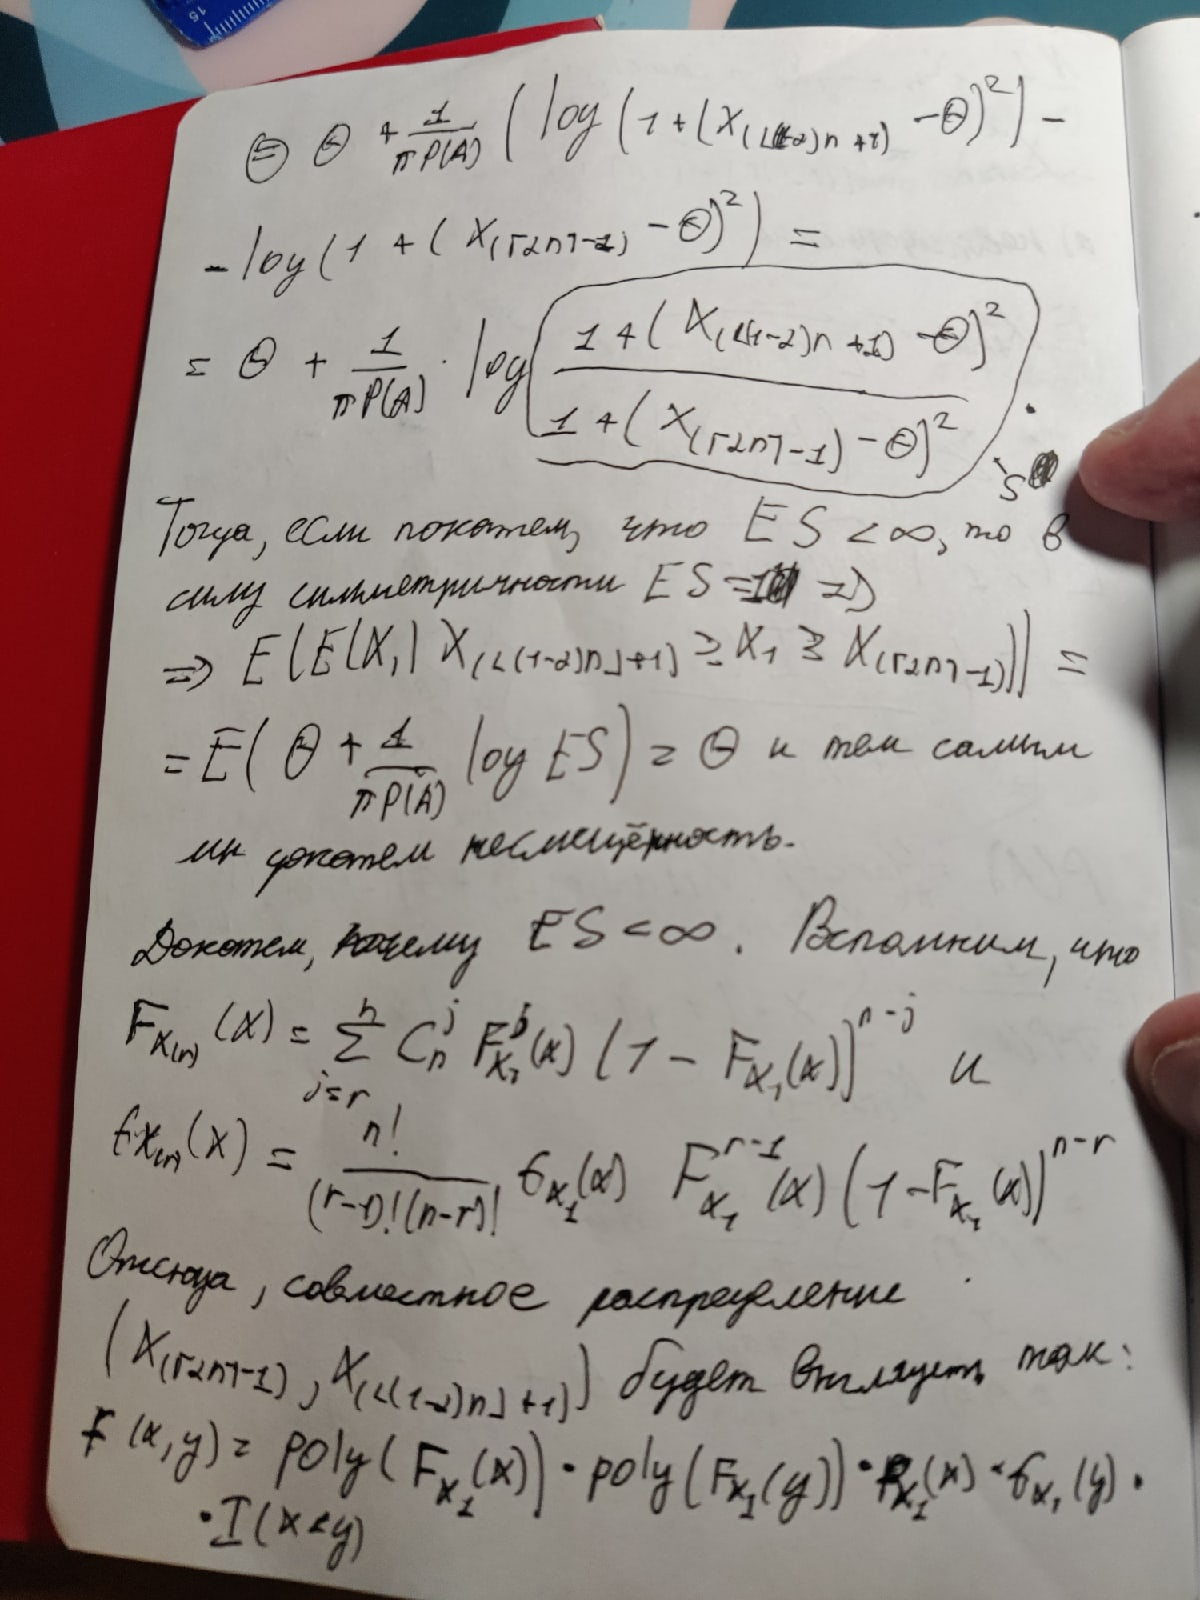

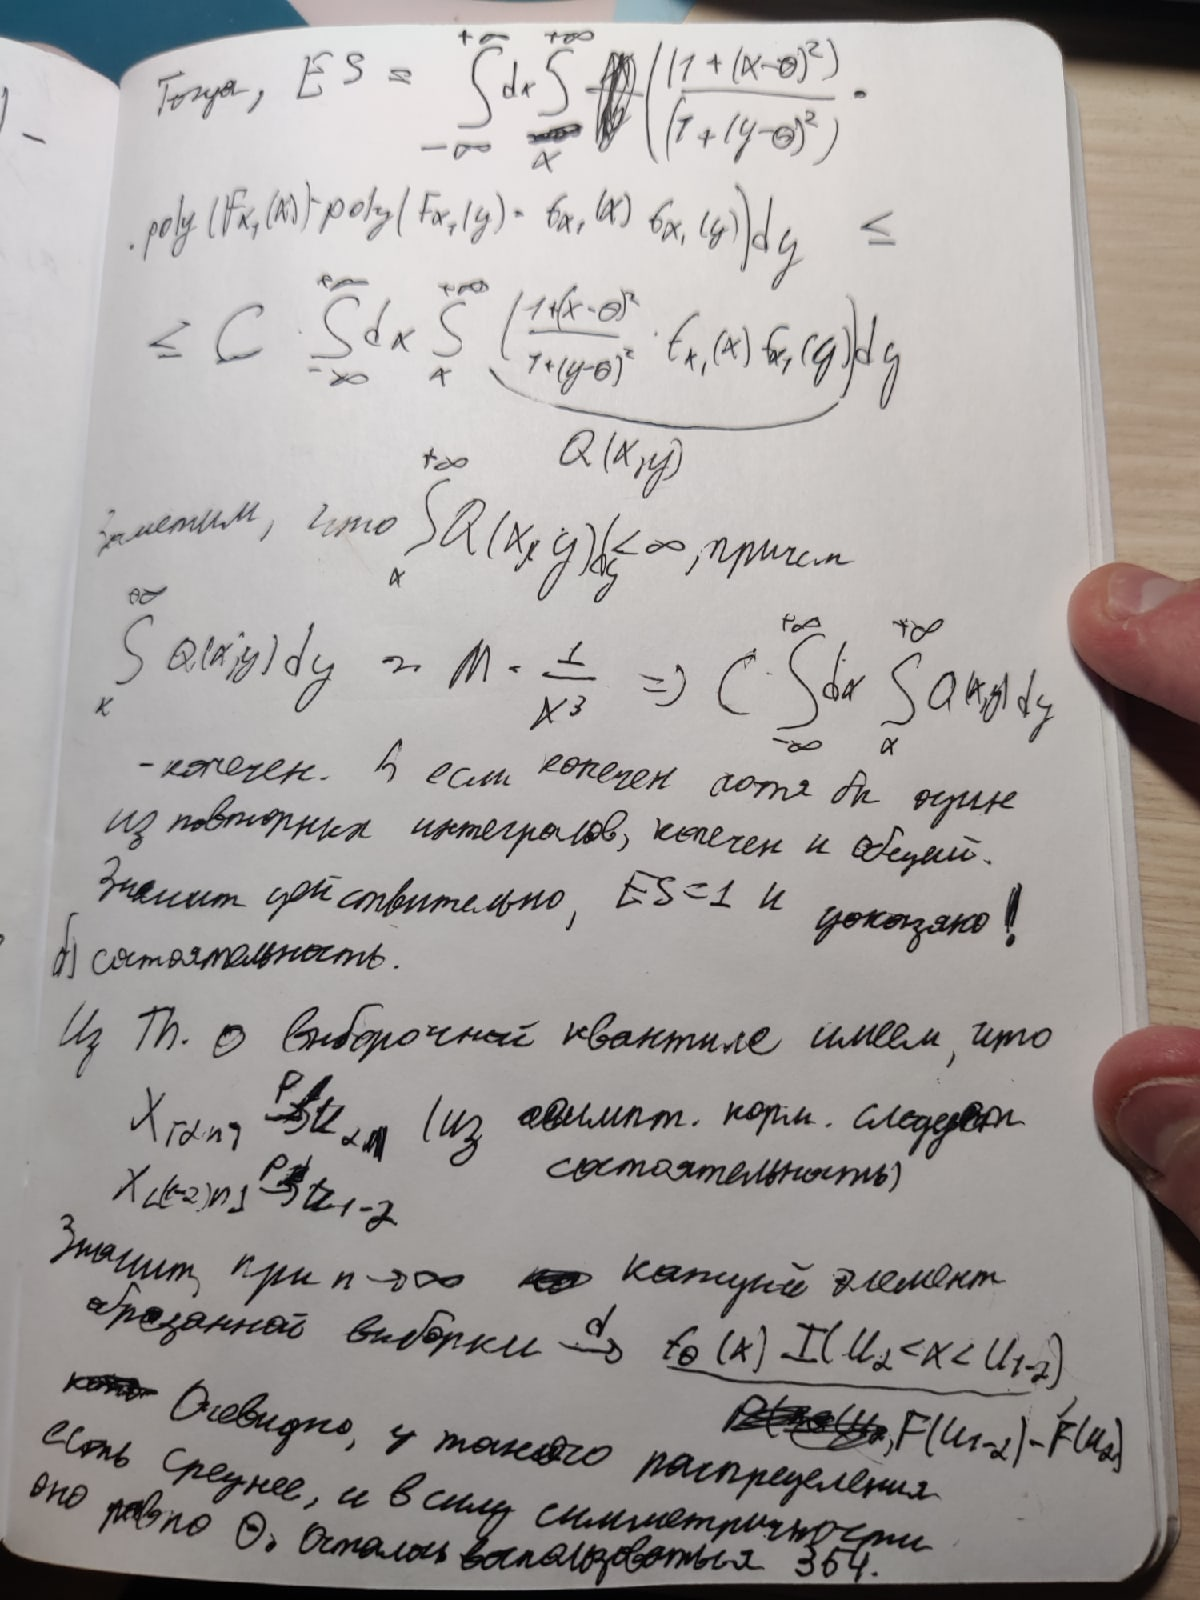

### Задача 2

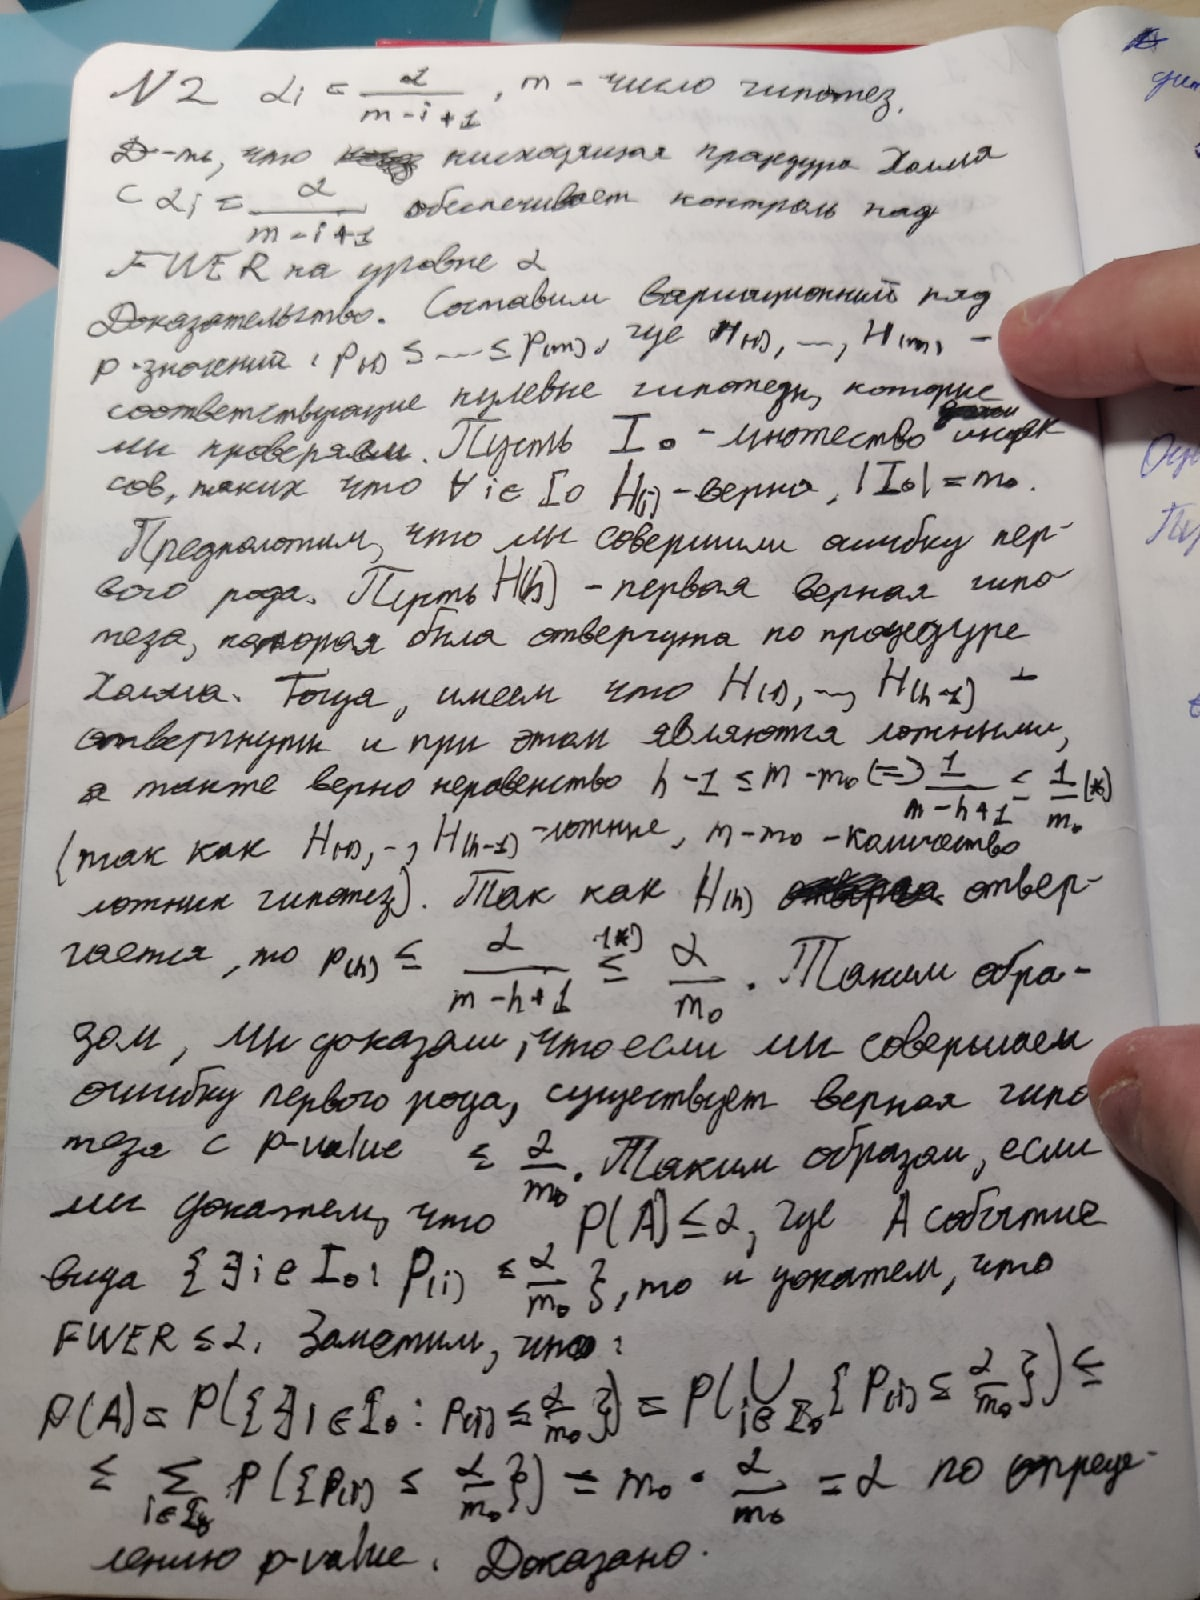

### Задача 3

Считаем данные и построим гистограмму.

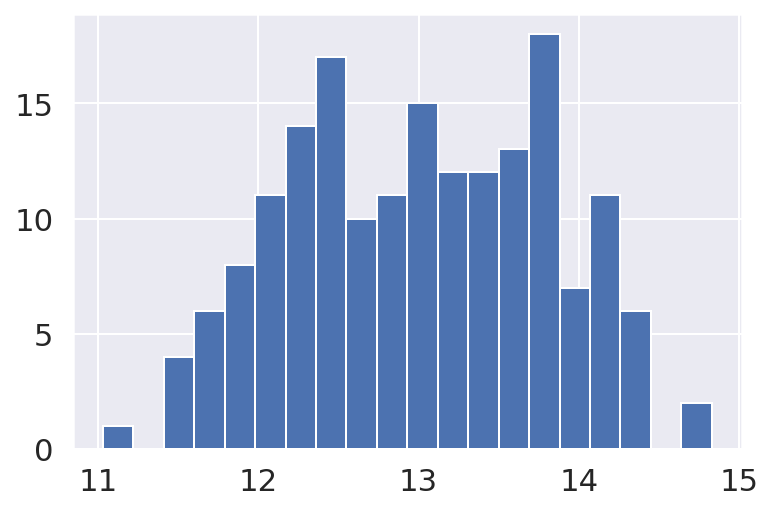

In [5]:
data = pd.read_csv("wine.data")
sample = data.iloc[: , 1]
sample = np.append(sample, float(data.columns[1]))
plt.hist(sample, bins = 20)
plt.show()

In [6]:
loc_like, scale_like = sample.mean(), np.sqrt(sample.var())

Судя по гистограмме, а также исходя из того факта, что перед нами процент алкоголя в вине, можно сделать вывод, что выбросов скореее всего здесь нету.

 Критерии проверки нормальности возьмем следующие: критерий Шапиро-Уилка, критерий K^2, критерий Лиллифорса, критерий Смирнова-Крамера-Фон-Мизеса с подстановкой омп. оценки и критерий Харке-Бера. 

In [7]:
p_vals = [sps.shapiro(sample)[1], sps.normaltest(sample)[1], lilliefors(sample)[1],
         sps.cramervonmises(sample, sps.norm(loc = loc_like, scale = scale_like).cdf).pvalue,
          sps.jarque_bera(sample)[1]]
p_vals

[0.02005171775817871,
 0.00034163202531285264,
 0.05838225305113938,
 0.316562602978262,
 0.061067754785150585]

Будем использовать нисходящую процедуру Холма, так как о независимости ничего неизвестно. Она как раз контролирует FWER.

In [8]:
def holm(pvalues, alpha):
    m = pvalues.shape[0]
    pvals_sorted = sorted(pvalues)
    stop = m
    for i, pval in enumerate(pvals_sorted):
        if pval >= alpha/(m - i):
            stop = i
            break
    return pvalues >= pvals_sorted[i]

Зафиксируем FWER на уровне 0.05 и проверим:

In [9]:
al = 0.05
holm(np.array(p_vals), al)

array([ True, False,  True,  True,  True])

 Одна из пяти гипотез отвергаются, а значит мы отвергаем гипотезу о нормальности данных

Сравним наш результат с метода Холма с библиотечным. Замечание -- здесь возвращается True, если нулевая гипотеза отвергается, в отличие от нашей реализации.
https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html 

In [10]:
multipletests(np.array(p_vals), al, method = 'holm', returnsorted = False)[0]

array([False,  True, False, False, False])

Как видим, результат получился идентичным.

### Задача 4

Зафиксируем уровень значимости, на котором хотим проверить экспоненциальность.

In [39]:
al = 0.05

Считаем данные и нарисуем гистограмму.

(array([994.,   2.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,   1.]),
 array([2.29976211e-03, 4.92081821e+02, 9.84161342e+02, 1.47624086e+03,
        1.96832038e+03, 2.46039990e+03, 2.95247943e+03, 3.44455895e+03,
        3.93663847e+03, 4.42871799e+03, 4.92079751e+03]),
 <BarContainer object of 10 artists>)

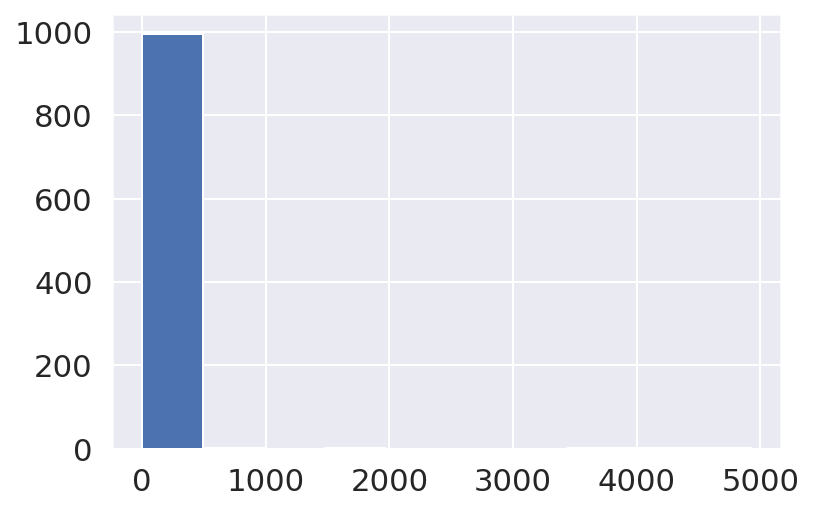

In [40]:
data = np.load("hw4t4.npy")
plt.hist(data, bins = 10)

In [41]:
print(max(data), min(data))

4920.797509006718 0.0022997621116264506


Странно, что лампочки горят больше 50 лет. Явно есть выбросы, и с этим нужно будет бороться. Будем использовать IsolationForest. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest

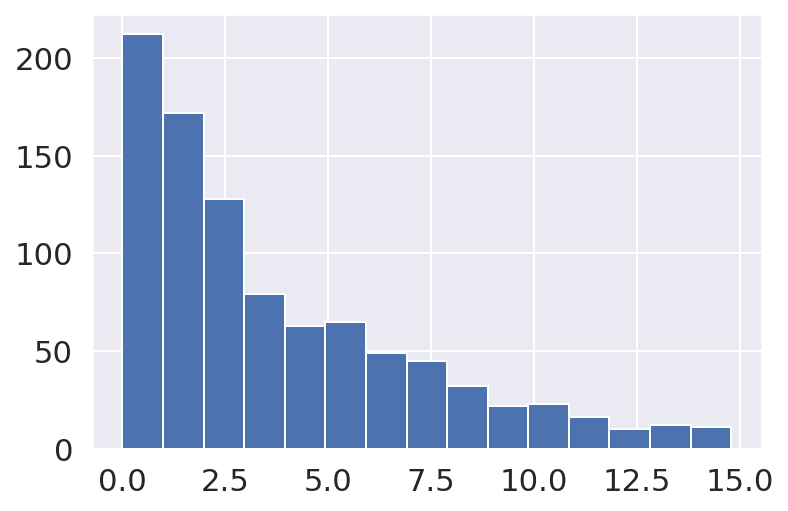

In [42]:
clf = IsolationForest()
clf.fit(data.reshape(-1, 1))
y = clf.predict(data.reshape(-1, 1))
data = data[y == 1]
plt.hist(data, bins = 15)
plt.show()

In [43]:
maxi = max(data)

Так уже намного лучше. Проверим наши данные на экспоненциальность с помощью множественной преверки гипотез контролируя FWER на уровне значимости 0.05. Критерии возьмем следующие -- Колмогорова-Смирнова с подстановкой в качестве параметра состоятельной оценки по методу моментов  и критерий Андерсона-Дарлинга. Можно было еще добавить обобщенный хи-квадрат, но он плохо работает с выбросами, которые есть у экспоненциального распределения.

In [44]:
lam = 1 / data.mean()
lam

0.2654138858183897

In [45]:
vec_boxes = np.array([[0, 2], [2, 4], [4, 6], [6, 8], [8, 10], [10, maxi]])

In [46]:
sps.kstest(data, sps.expon(scale = 1 / lam).cdf)

KstestResult(statistic=0.03767535792589083, pvalue=0.13558027803950667)

In [47]:
sps.anderson(data, "expon")

AndersonResult(statistic=1.5961154907466835, critical_values=array([0.921, 1.077, 1.34 , 1.605, 1.956]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [48]:
sps.anderson(data, 'expon')

AndersonResult(statistic=1.5961154907466835, critical_values=array([0.921, 1.077, 1.34 , 1.605, 1.956]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Реализованный критерий Андерсона не выдал нам p-value, но мы точно знаем, что он больше 0.025, так как статистика меньше критического значения. Таким образом, по процедуре Холма обе гипотезы будут не отвергнуты, так как $p_{(1)} \approx 0.026, p_{(2)} \approx 0.135$, $\alpha_1 = \frac{\alpha}{2} = 0.025, \alpha_2 = 0.05$. Таким образом, гипотеза об экспоненциальности распределения срока действия лампочек.

В качестве оценки среднего срока действия одной лампочки (я это понял как математическое ожидание срока действия одной лампочки), можно взять выборочное среднее, которое будет несмещенной оценкой для него, а также  при условии существования первого момента -- сильно состоятельной оценкой, а также при существовании второго момента -- асимптотически нормальной оценкой. При условии верности гипотезы о принадлежности данных эспоненциальному распределению, оба момента существуют. 

### Задача 5

Считаем данные. Будем использовать следующие 5 критериев -- критерий Шапиро-Уилка, критерий К^2, критерий Лиллифорса, критерий Смирнова-Крамера-Фон-Мизеса с подстановкой омп. оценки и критерий Харке-Бера. 

In [21]:
al = 0.05

In [22]:
samples = []
data = pd.read_csv("wine.data")
for ind in [1, 3, 8, 9]:
    sample = data.iloc[: , ind]
    sample = np.append(sample, float(data.columns[ind]))
    samples.append(sample)
data = pd.read_csv("go_track_tracks.csv")
for ind in ["speed", "distance"]:
    samples.append(np.array(data[ind]))
data = pd.read_csv("abalone.data")
for ind in [5, 6, 7]:
    sample = data.iloc[: , ind]
    sample = np.append(sample, float(data.columns[ind]))
    samples.append(np.array(sample))

Посмотрим, есть ли выбросы в выборках:

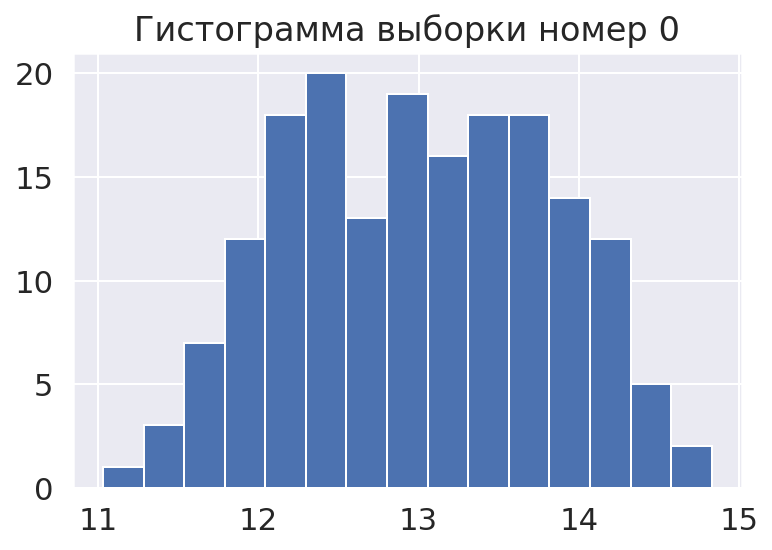

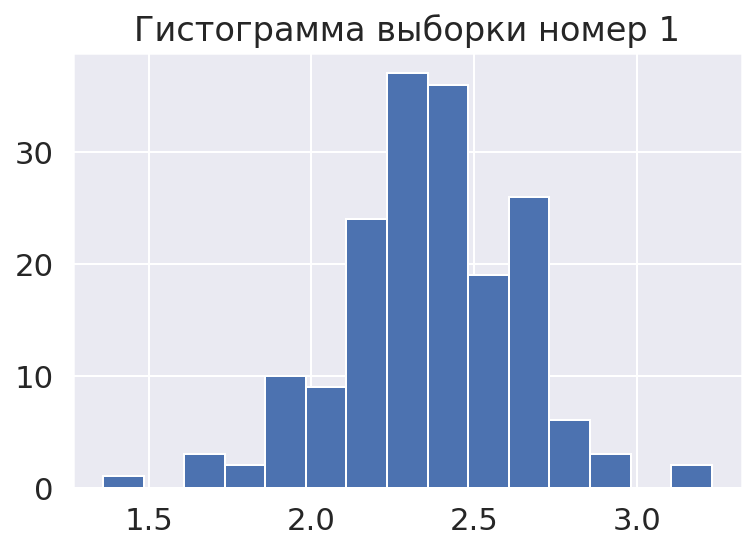

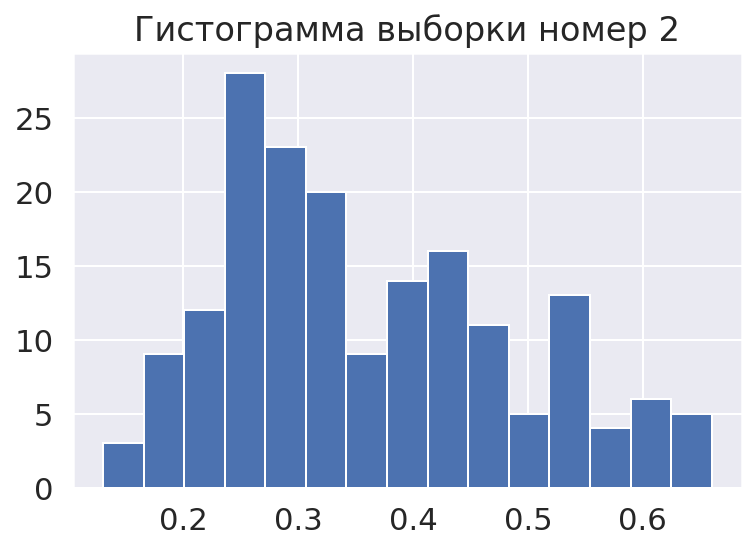

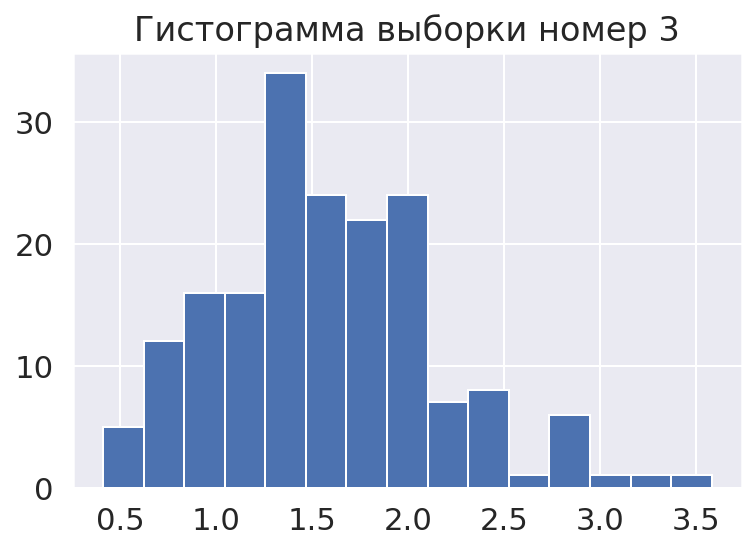

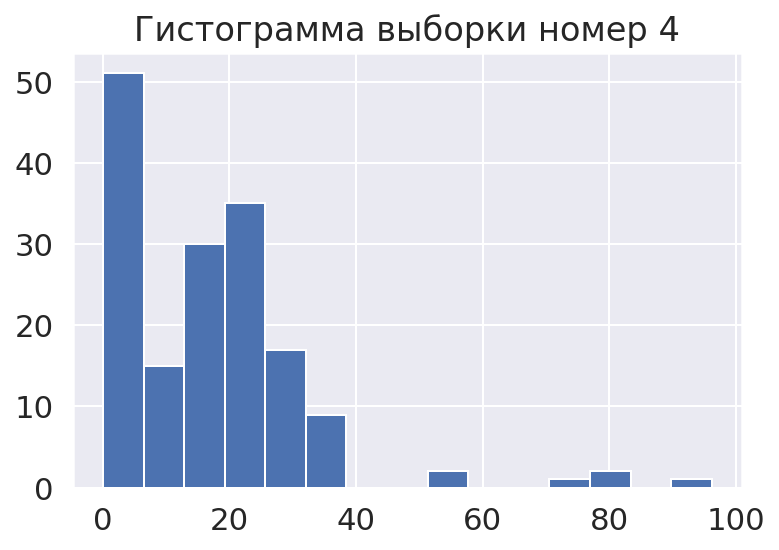

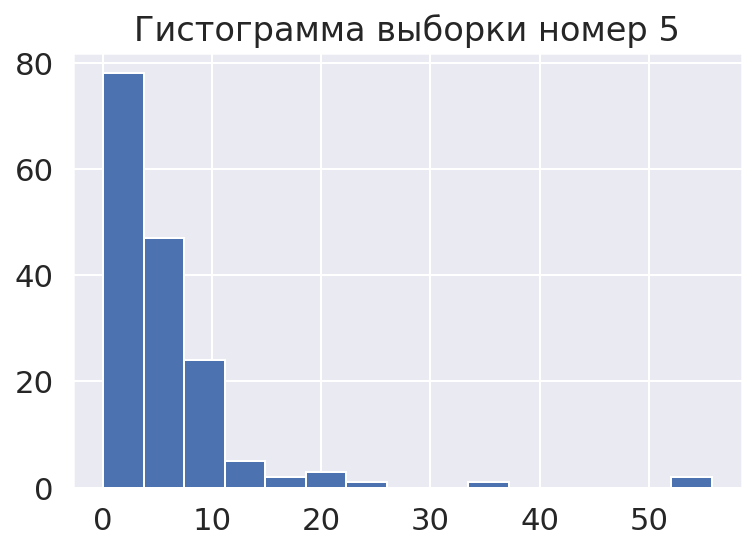

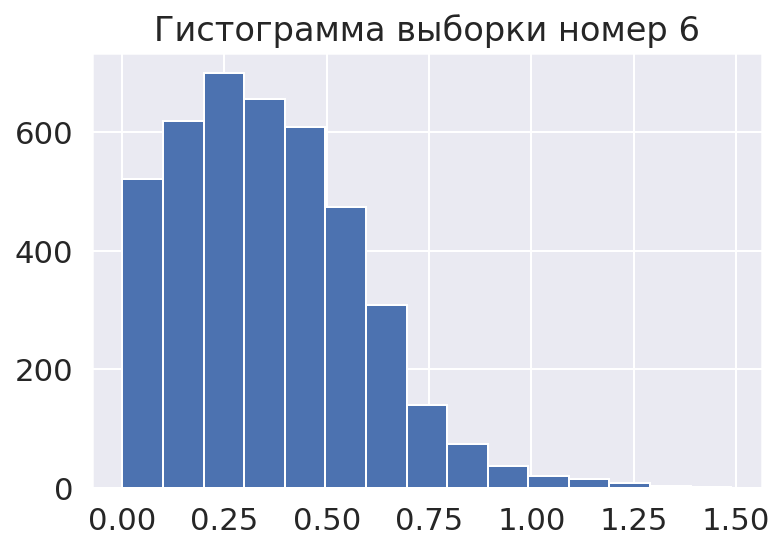

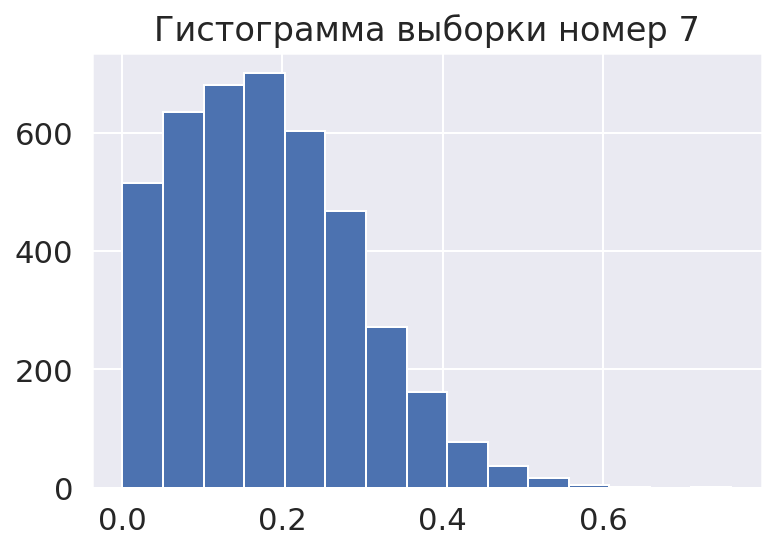

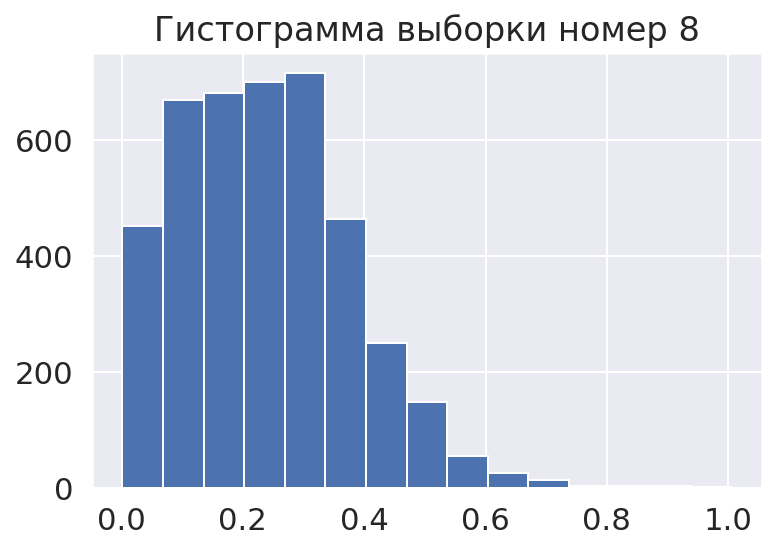

In [23]:
for ind, sample in enumerate(samples):
    plt.hist(sample, bins = 15)
    plt.title(f"Гистограмма выборки номер {ind}")
    plt.show()

Кажется, что выбросы есть только в выборках 4 и 5. Там сделаем Isolation Forest.

Далее, алгоритм следующий: мы все гипотезы кидаем в один мешок и используем метод Бенджамини-Иекутелли. Метод Бенджамини-Хохберга применять нельзя, так как для одной выборки применяется несколько критериев и статистики в них могут быть зависимыми.

In [24]:
batch = []
to_clear = [4, 5]
for  ind, sample in enumerate(samples):
    if ind in to_clear:       
        clf = IsolationForest(random_state = 5)
        clf.fit(sample.reshape(-1, 1))
        y = clf.predict(sample.reshape(-1, 1))
        sample = sample[y == 1]
    loc_like, scale_like = sample.mean(), np.sqrt(sample.var()) 
    batch.append({'num_sample': ind, 'method' : "Shapiro", 'pval' : sps.shapiro(sample)[1]})
    batch.append({'num_sample': ind, 'method' : "K^2", 'pval' : sps.normaltest(sample)[1]})
    batch.append({'num_sample': ind, 'method' : "Lilliforce", 'pval' : lilliefors(sample)[1]})
    batch.append({'num_sample': ind, 
                      'method' : "Von Mises", 'pval' : sps.cramervonmises(sample, sps.norm(loc = loc_like, scale = scale_like).cdf).pvalue})
    batch.append({'num_sample': ind, 'method' : "Jarque_Berr", 'pval' : sps.jarque_bera(sample)[1]})

In [25]:
p_vals = []
for elem in batch:
    p_vals.append(elem['pval'])

In [26]:
batch

[{'num_sample': 0, 'method': 'Shapiro', 'pval': 0.02005171775817871},
 {'num_sample': 0, 'method': 'K^2', 'pval': 0.00034163202531285264},
 {'num_sample': 0, 'method': 'Lilliforce', 'pval': 0.05838225305113938},
 {'num_sample': 0, 'method': 'Von Mises', 'pval': 0.316562602978262},
 {'num_sample': 0, 'method': 'Jarque_Berr', 'pval': 0.061067754785150585},
 {'num_sample': 1, 'method': 'Shapiro', 'pval': 0.03868526220321655},
 {'num_sample': 1, 'method': 'K^2', 'pval': 0.03631602067034479},
 {'num_sample': 1, 'method': 'Lilliforce', 'pval': 0.18650410337626436},
 {'num_sample': 1, 'method': 'Von Mises', 'pval': 0.596121790395941},
 {'num_sample': 1, 'method': 'Jarque_Berr', 'pval': 0.008485916875615285},
 {'num_sample': 2, 'method': 'Shapiro', 'pval': 0.00010552661115070805},
 {'num_sample': 2, 'method': 'K^2', 'pval': 0.00266470257270766},
 {'num_sample': 2, 'method': 'Lilliforce', 'pval': 0.0009999999999998899},
 {'num_sample': 2, 'method': 'Von Mises', 'pval': 0.0833957701418917},
 {'n

Будем использовать метод  Бенджамини-Иекутелли с библиотеки и собственноручный. True возвращается, если гипотеза отверглась, False -- иначе.

In [27]:
ans_lib = multipletests(np.array(p_vals), alpha = al, method = "fdr_by")[0]
print(ans_lib)

[False  True False False False False False False False False  True  True
  True False False False False False False False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]


In [28]:
def Iekutelli(pvalues, alpha):
    m = pvalues.shape[0]
    sort_p = sorted(pvalues, reverse=True)
    stop = -1
    const = (1./(1+np.arange(m))).sum()
    for i, pval in enumerate(sort_p):
        if pval < alpha*(m - i)/(m*const):
            stop = m - i
            break
    return pvalues <= sort_p[m - stop]

In [29]:
ans = Iekutelli(np.array(p_vals), al)
print(ans)

[False  True False False False False False False False False  True  True
  True False False False False False False False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]


Метод из библиотеки совпали. Теперь проверим, у каких выборок какие гипотезы не отверглись. У тех выборок , у которых не отверглась ни одна гипотеза, гипотеза о нормальности отвеграться не будет.

In [30]:
num_methods = 5

for idx in range(len(samples)):
    flag = True
    for i in range(num_methods):
        if ans[idx * num_methods + i]:
            flag = False
            break
    if flag:
        print(f"Выборка под номером {idx} не отвергается")
    else:
        print(f"Выборка под номером {idx} отвергается")

Выборка под номером 0 отвергается
Выборка под номером 1 не отвергается
Выборка под номером 2 отвергается
Выборка под номером 3 не отвергается
Выборка под номером 4 отвергается
Выборка под номером 5 отвергается
Выборка под номером 6 отвергается
Выборка под номером 7 отвергается
Выборка под номером 8 отвергается


Посмотрим, что скажут результаты из библиотеки.

In [31]:
for idx in range(len(samples)):
    flag = True
    for i in range(num_methods):
        if ans_lib[idx * num_methods + i]:
            flag = False
            break
    if flag:
        print(f"Выборка под номером {idx} не отвергается")
    else:
        print(f"Выборка под номером {idx} отвергается")

Выборка под номером 0 отвергается
Выборка под номером 1 не отвергается
Выборка под номером 2 отвергается
Выборка под номером 3 не отвергается
Выборка под номером 4 отвергается
Выборка под номером 5 отвергается
Выборка под номером 6 отвергается
Выборка под номером 7 отвергается
Выборка под номером 8 отвергается


Совпало!

Далее работаем в $\textbf{предположении}$, что выборки независимы.

Теперь попробуем другой подход, где уже можно будет использовать метод Бенджамини-Хохберга. Объединим в батчи гипотезы на разных выборказ с одинаковыми критериями. Для каждого батча запустим множественную проверку гипотез с контролем FDR $\alpha$. Причем, в этот раз уже можно  использовать метод Бенджамини-Хохберга, так как выборки независимы. Тогда, так как вероятность объединения меньше или равна сумме вероятностей, для всех гипотез мы получим проверку с контролем FDR на уровне $n \cdot \alpha$, где $n$ -- число критериев. 

Посмотрим, что покажет данный подход.

In [32]:
def Hochberg(pvalues, alpha):
    m = pvalues.shape[0]
    sort_p = sorted(pvalues, reverse=True)
    stop = -1
    for i, pval in enumerate(sort_p):
        if pval < alpha*(m - i)/m:
            stop = m - i
            break
    return pvalues <= sort_p[m - stop]

In [33]:
batches = dict()
methods = ["Shapiro", "K^2",   "Lilliforce", "Von Mises", "Jarque_Berr"]
for m in methods:
    batches[m] = []

In [34]:
for elem in batch:
    batches[elem["method"]].append(elem["pval"])

In [35]:
al_batch = al / num_methods

In [36]:
results = dict()

for method, pvals in batches.items():
    results[method] =  Hochberg(np.array(pvals), al_batch)

In [37]:
results

{'Shapiro': array([False, False,  True, False,  True,  True,  True,  True,  True]),
 'K^2': array([ True, False,  True,  True,  True,  True,  True,  True,  True]),
 'Lilliforce': array([False, False,  True, False,  True,  True,  True,  True,  True]),
 'Von Mises': array([False, False, False, False, False,  True,  True,  True,  True]),
 'Jarque_Berr': array([False, False, False, False,  True,  True,  True,  True,  True])}

In [38]:
num_methods = 5

for idx in range(len(samples)):
    flag = True
    for m in methods:
        if results[m][idx]:
            flag = False
            break
    if flag:
        print(f"Выборка под номером {idx} не отвергается")
    else:
        print(f"Выборка под номером {idx} отвергается")

Выборка под номером 0 отвергается
Выборка под номером 1 не отвергается
Выборка под номером 2 отвергается
Выборка под номером 3 отвергается
Выборка под номером 4 отвергается
Выборка под номером 5 отвергается
Выборка под номером 6 отвергается
Выборка под номером 7 отвергается
Выборка под номером 8 отвергается


Как видим, этот критерий отверг гипотезу о принадлежности четвертой выборке к классу нормальных, в отличие от прошлой процедуры.